In [ ]:
!pip install tensorflow==2.17.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: Operation cancelled by user


In [ ]:
import keras
print(keras.__version__)

3.4.1


In [4]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 43.3 MB/s eta 0:00:00


In [69]:
from keras.models import load_model

model_path = '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/model/_mini_XCEPTION.102-0.66.hdf5'

model = load_model(model_path, compile=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Emotion probabilities: 
Angry: 0.08
Disgust: 0.01
Fear: 0.16
Happy: 0.14
Sad: 0.15
Surprise: 0.13
Neutral: 0.34
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Emotion probabilities: 
Angry: 0.68
Disgust: 0.15
Fear: 0.07
Happy: 0.02
Sad: 0.03
Surprise: 0.02
Neutral: 0.03


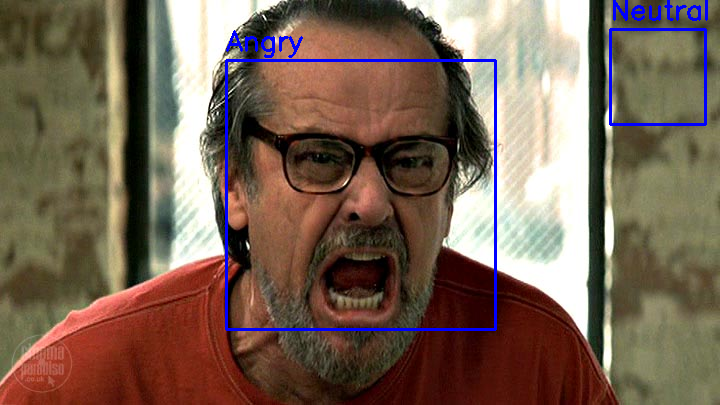

In [81]:
# 전처리 전

import numpy as np
import cv2
from google.colab.patches import cv2_imshow #imshow 사용

def load_and_preprocess_image(image_path):
    # 이미지 로드
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 흑백 이미지로 변환
    faces = face_cascade.detectMultiScale(
        gray, scaleFactor=1.1, minNeighbors=5, minSize=(10, 10) # 박스 크기 제한(미리필터링)
    )


    for (x, y, w, h) in faces:

      # 얼굴 영역을 모델 입력 크기에 맞게 조정
      face_img = gray[y:y+h, x:x+w]
      face_img = cv2.resize(face_img, (64, 64))
      face_img = face_img / 255.0  # 픽셀 값을 [0, 1] 범위로 정규화
      face_img = face_img.reshape(1, 64, 64, 1)  # 배치 차원 추가

      # 감정 예측
      predictions = model.predict(face_img)
      predicted_class = np.argmax(predictions, axis=1)[0]

      # 감정 라벨 설정
      emotion_label = emotion_dict[predicted_class]

      # 감정 클래스별 확률 출력
      print("Emotion probabilities: ")
      for i, prob in enumerate(predictions[0]):
        print(f"{emotion_dict[i]}: {prob:.2f}")

      # 얼굴 감지된 부분에 네모 표시 및 감정 출력
      cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
      cv2.putText(img, emotion_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    return img

# OpenCV의 얼굴 검출기 로드 (얼굴 감지용 haarcascade 파일)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# 감정 라벨 딕셔너리
emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

# 이미지 로드 및 감정 분석 후 표시
image_path = '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/angrysss.jpg'
processed_image = load_and_preprocess_image(image_path)
cv2_imshow(processed_image)

In [71]:
# 전처리 전 정확도

from sklearn.metrics import accuracy_score

def load_and_preprocess_image(image_path, true_label):
    # 이미지 로드
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 흑백 이미지로 변환
    faces = face_cascade.detectMultiScale(
        gray, scaleFactor=1.1, minNeighbors=5, minSize=(10, 10)  # 박스 크기 제한
    )

    predicted_labels = []  # 예측된 레이블을 저장할 리스트
    face_detections = []  # 실제 얼굴 감지 여부를 저장할 리스트 (True: 얼굴, False: 배경)

    for (x, y, w, h) in faces:
        # 얼굴 영역을 모델 입력 크기에 맞게 조정
        face_img = gray[y:y + h, x:x + w]
        face_img = cv2.resize(face_img, (64, 64))
        face_img = face_img / 255.0  # 픽셀 값을 [0, 1] 범위로 정규화
        face_img = face_img.reshape(1, 64, 64, 1)  # 배치 차원 추가

        # 감정 예측
        predictions = model.predict(face_img)
        predicted_class = np.argmax(predictions, axis=1)[0]
        predicted_labels.append(predicted_class)

        # 얼굴과 배경 구분 (예: 영역 크기 조건 사용)
        if w * h > 10000:  # 임계값을 조정하여 작은 배경을 필터링
            face_detections.append(True)  # 얼굴로 간주
        else:
            face_detections.append(False)  # 배경으로 간주

    return predicted_labels, face_detections

def calculate_metrics(image_paths, true_labels):
    total_faces = 0  # 전체 얼굴 수
    correctly_detected_faces = 0  # 정확히 예측된 얼굴 수
    false_positives = 0  # 잘못된 배경 감정 검출 수
    total_detections = 0  # 총 감정 검출 수

    for image_path, true_label in zip(image_paths, true_labels):
        predicted_labels, face_detections = load_and_preprocess_image(image_path, true_label)

        for is_face, predicted_label in zip(face_detections, predicted_labels):
            total_detections += 1
            if is_face:
                total_faces += 1
                if predicted_label == true_label:
                    correctly_detected_faces += 1
            else:
                false_positives += 1

    # 얼굴 감정 정확도 계산
    face_accuracy = (correctly_detected_faces / total_faces) * 100 if total_faces > 0 else 0

    # 잘못된 검출 비율 계산
    false_positive_rate = (false_positives / total_detections) * 100 if total_detections > 0 else 0

    print(f"Face Emotion Accuracy: {face_accuracy:.2f}%")
    print(f"False Positive Rate: {false_positive_rate:.2f}%")

    return face_accuracy, false_positive_rate

# OpenCV의 얼굴 검출기 로드 (얼굴 감지용 haarcascade 파일)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# 감정 라벨 딕셔너리
emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

# 테스트 데이터
image_paths = [
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/angry.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/angry2.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/angrysss.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/disgust.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/disgust2.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/disgust_sad.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/fear.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/fear2.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/harry.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/happy2.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/neutral.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/neutral2.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/neutral_fear.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/neutralsss.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/sad.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/sad2.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/surprise.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/surprise2.jpg'
]
true_labels = [0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 6, 6, 6, 6, 4, 4, 5, 5]

calculate_metrics(image_paths, true_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Face Emotion Accuracy: 94.44%
False Positive Rate: 18.18%


(94.44444444444444, 18.181818181818183)

skip (box size: (95, 95))
skip (stddev: 22.18)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Emotion probabilities: 
Angry: 0.68
Disgust: 0.15
Fear: 0.07
Happy: 0.02
Sad: 0.03
Surprise: 0.02
Neutral: 0.03


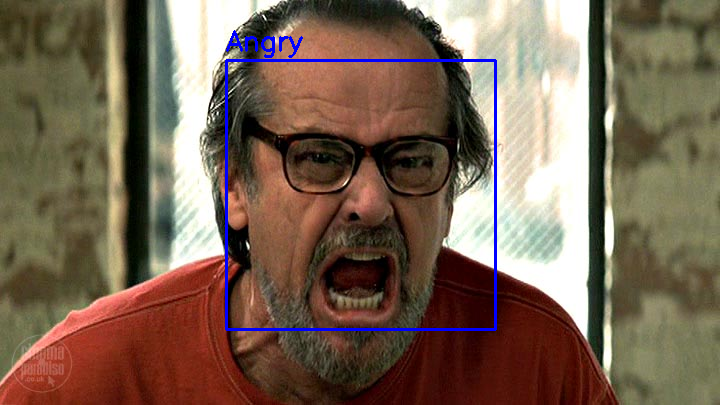

In [80]:
# 전처리1 - boxsize, stddev

import numpy as np
import cv2
from google.colab.patches import cv2_imshow #imshow 사용

def load_and_preprocess_image(image_path):
    # 이미지 로드
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 흑백 이미지로 변환
    faces = face_cascade.detectMultiScale(
        gray, scaleFactor=1.1, minNeighbors=5, minSize=(10, 10) # 박스 크기 제한(미리필터링)
    )

    for (x, y, w, h) in faces:
      # 평균, 표준편차 계산
      roi_mean, roi_stddev = cv2.meanStdDev(gray[y:y+h, x:x+w])

      if w < 100 or h < 100: # 필터링 안했을때 거침
        print(f"skip (box size: ({w}, {h}))")
      if roi_stddev[0][0] < 33:
        print(f"skip (stddev: {roi_stddev[0][0]:.2f})")
        continue

      # 얼굴 영역을 모델 입력 크기에 맞게 조정
      face_img = gray[y:y+h, x:x+w]
      face_img = cv2.resize(face_img, (64, 64))
      face_img = face_img / 255.0  # 픽셀 값을 [0, 1] 범위로 정규화
      face_img = face_img.reshape(1, 64, 64, 1)  # 배치 차원 추가

      # 감정 예측
      predictions = model.predict(face_img)
      predicted_class = np.argmax(predictions, axis=1)[0]
      # confidence = predictions[0][predicted_class] # 가장 높은 확률


      # 감정 라벨 설정
      emotion_label = emotion_dict[predicted_class]

      # 감정 클래스별 확률 출력
      print("Emotion probabilities: ")
      for i, prob in enumerate(predictions[0]):
        print(f"{emotion_dict[i]}: {prob:.2f}")

      # 얼굴 감지된 부분에 네모 표시 및 감정 출력
      cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
      cv2.putText(img, emotion_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    return img

# OpenCV의 얼굴 검출기 로드 (얼굴 감지용 haarcascade 파일)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# 감정 라벨 딕셔너리
emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

# 이미지 로드 및 감정 분석 후 표시
image_path = '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/angrysss.jpg'
processed_image = load_and_preprocess_image(image_path)

# 이미지 출력
cv2_imshow(processed_image)

In [73]:
# 전처리1 후 정확도
import cv2
from sklearn.metrics import accuracy_score

def load_and_preprocess_image(image_path, true_label):
    # 이미지 로드
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 흑백 이미지로 변환
    faces = face_cascade.detectMultiScale(
        gray, scaleFactor=1.1, minNeighbors=5, minSize=(10, 10)  # 박스 크기 제한
    )


    predicted_labels = []  # 예측된 레이블을 저장할 리스트
    face_detections = []  # 실제 얼굴 감지 여부를 저장할 리스트 (True: 얼굴, False: 배경)

    for (x, y, w, h) in faces:
      # 평균, 표준편차 계산
      roi_mean, roi_stddev = cv2.meanStdDev(gray[y:y+h, x:x+w])

      if w < 100 or h < 100: # 필터링 안했을때 거침
        print(f"skip (box size: ({w}, {h}))")
      if roi_stddev[0][0] < 33:
        print(f"skip (stddev: {roi_stddev[0][0]:.2f})")
        continue

      # 얼굴 영역을 모델 입력 크기에 맞게 조정
      face_img = gray[y:y + h, x:x + w]
      face_img = cv2.resize(face_img, (64, 64))
      face_img = face_img / 255.0  # 픽셀 값을 [0, 1] 범위로 정규화
      face_img = face_img.reshape(1, 64, 64, 1)  # 배치 차원 추가

      # 감정 예측
      predictions = model.predict(face_img)
      predicted_class = np.argmax(predictions, axis=1)[0]
      predicted_labels.append(predicted_class)

      # 얼굴과 배경 구분 (예: 영역 크기 조건 사용)
      if w * h > 10000:  # 임계값을 조정하여 작은 배경을 필터링
          face_detections.append(True)  # 얼굴로 간주
      else:
          face_detections.append(False)  # 배경으로 간주

    return predicted_labels, face_detections

def calculate_metrics(image_paths, true_labels):
    total_faces = 0  # 전체 얼굴 수
    correctly_detected_faces = 0  # 정확히 예측된 얼굴 수
    false_positives = 0  # 잘못된 배경 감정 검출 수
    total_detections = 0  # 총 감정 검출 수

    for image_path, true_label in zip(image_paths, true_labels):
        predicted_labels, face_detections = load_and_preprocess_image(image_path, true_label)

        for is_face, predicted_label in zip(face_detections, predicted_labels):
            total_detections += 1
            if is_face:
                total_faces += 1
                if predicted_label == true_label:
                    correctly_detected_faces += 1
            else:
                false_positives += 1

    # 얼굴 감정 정확도 계산
    face_accuracy = (correctly_detected_faces / total_faces) * 100 if total_faces > 0 else 0

    # 잘못된 검출 비율 계산
    false_positive_rate = (false_positives / total_detections) * 100 if total_detections > 0 else 0

    print(f"Face Emotion Accuracy: {face_accuracy:.2f}%")
    print(f"False Positive Rate: {false_positive_rate:.2f}%")

    return face_accuracy, false_positive_rate

# OpenCV의 얼굴 검출기 로드 (얼굴 감지용 haarcascade 파일)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# 감정 라벨 딕셔너리
emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

# 테스트 데이터
image_paths = [
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/angry.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/angry2.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/angrysss.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/disgust.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/disgust2.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/disgust_sad.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/fear.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/fear2.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/harry.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/happy2.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/neutral.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/neutral2.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/neutral_fear.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/neutralsss.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/sad.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/sad2.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/surprise.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/surprise2.jpg'
]
true_labels = [0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 6, 6, 6, 6, 4, 4, 5, 5]

calculate_metrics(image_paths, true_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
skip (box size: (95, 95))
skip (stddev: 22.18)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
skip (box size: (56, 56))
skip (stddev: 20.55)
skip (stddev: 31.58)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
skip (box size: (90, 90))
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
skip (box size: (63, 63))
skip (stddev: 20.32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Face Emotion Accuracy: 94.12%
False Positive Rate: 5.56%


(94.11764705882352, 5.555555555555555)

In [74]:
# 전처리2 - mediapipe

import cv2
import mediapipe as mp
import numpy as np
from sklearn.metrics import accuracy_score

# MediaPipe 얼굴 검출 모델 로드
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

def load_and_preprocess_image(image_path, true_label):
    # 이미지 로드
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 흑백 이미지로 변환

    # MediaPipe FaceDetection 초기화
    with mp_face_detection.FaceDetection(min_detection_confidence=0.2) as face_detection:
        results = face_detection.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # RGB로 변환 후 처리

    predicted_labels = []  # 예측된 레이블을 저장할 리스트
    face_detections = []  # 실제 얼굴 감지 여부를 저장할 리스트 (True: 얼굴, False: 배경)

    if results.detections:
        for detection in results.detections:
            bboxC = detection.location_data.relative_bounding_box
            ih, iw, _ = img.shape
            x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)

            # 얼굴 영역을 모델 입력 크기에 맞게 조정
            face_img = gray[y:y + h, x:x + w]
            face_img = cv2.resize(face_img, (64, 64))
            face_img = face_img / 255.0  # 픽셀 값을 [0, 1] 범위로 정규화
            face_img = face_img.reshape(1, 64, 64, 1)  # 배치 차원 추가

            # 감정 예측
            predictions = model.predict(face_img)
            predicted_class = np.argmax(predictions, axis=1)[0]
            predicted_labels.append(predicted_class)

            # 얼굴과 배경 구분 (예: 영역 크기 조건 사용)
            if w * h > 5000:  # 임계값을 조정하여 작은 배경을 필터링
                face_detections.append(True)  # 얼굴로 간주
            else:
                face_detections.append(False)  # 배경으로 간주
    else:
        print("No faces detected in this image.")

    return predicted_labels, face_detections

def calculate_metrics(image_paths, true_labels):
    total_faces = 0  # 전체 얼굴 수
    correctly_detected_faces = 0  # 정확히 예측된 얼굴 수
    false_positives = 0  # 잘못된 배경 감정 검출 수
    total_detections = 0  # 총 감정 검출 수

    for image_path, true_label in zip(image_paths, true_labels):
        predicted_labels, face_detections = load_and_preprocess_image(image_path, true_label)

        for is_face, predicted_label in zip(face_detections, predicted_labels):
            total_detections += 1
            if is_face:
                total_faces += 1
                if predicted_label == true_label:
                    correctly_detected_faces += 1
            else:
                false_positives += 1

    # 얼굴 감정 정확도 계산
    face_accuracy = (correctly_detected_faces / total_faces) * 100 if total_faces > 0 else 0

    # 잘못된 검출 비율 계산
    false_positive_rate = (false_positives / total_detections) * 100 if total_detections > 0 else 0

    print(f"Face Emotion Accuracy: {face_accuracy:.2f}%")
    print(f"False Positive Rate: {false_positive_rate:.2f}%")

    return face_accuracy, false_positive_rate

# 감정 라벨 딕셔너리
emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

# 테스트 데이터
image_paths = [
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/angry.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/angry2.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/angrysss.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/disgust.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/disgust2.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/disgust_sad.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/fear.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/fear2.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/harry.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/happy2.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/neutral.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/neutral2.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/neutral_fear.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/neutralsss.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/sad.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/sad2.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/surprise.jpg',
    '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/surprise2.jpg'
]
true_labels = [0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 6, 6, 6, 6, 4, 4, 5, 5]

calculate_metrics(image_paths, true_labels)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Face Emotion Accuracy: 65.00%
False Positive Rate: 0.00%


(65.0, 0.0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Detected emotion: Surprise


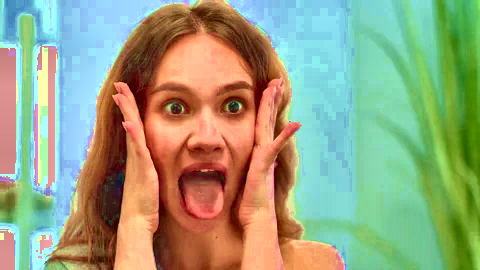

In [95]:
# 스타일링
# OpenCV의 얼굴 검출기 로드
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# 감정 라벨 딕셔너리
emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

# 감정에 따른 스타일링
def apply_emotion_style(img, emotion_class):
    if emotion_class == 0:  # Angry
        # 빨간색 강조 및 고주파 필터
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(img)
        # h += 1  # 빨간색 강조
        # v += 1
        h = cv2.add(h, 1)
        s = cv2.add(s, 40)  # 채도 증가
        v = cv2.add(v, 1)
        img = cv2.merge([h, s, v])
        img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
        kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
        img = cv2.filter2D(img, -1, kernel)

    elif emotion_class == 1:  # Disgust
        # 초록색 및 회색 계열
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(img)
        h = cv2.add(h, 5)   # 초록색으로 살짝 이동
        s = cv2.subtract(s, 5)  # 채도 소폭 증가
        v = cv2.subtract(v, 30)  # 살짝 어두운 느낌
        img = cv2.merge([h, s, v])
        img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)

    elif emotion_class == 2:  # Fear
        # 파란색 강조 및 흐림 효과
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(img)
        h = cv2.subtract(h, 15)  # 파란색 강조
        s = cv2.subtract(s, 10)  # 채도 소폭 감소
        v = cv2.subtract(v, 30)  # 살짝 어두운 느낌
        img = cv2.merge([h, s, v])
        img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
        # img = cv2.GaussianBlur(img, (21, 21), 0)

    elif emotion_class == 3:  # Happy
        # 따뜻한 색 강조 및 밝기/채도 증가
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(img)
        h = cv2.add(h, 8)
        # h += 8  # 노랑/주황 강조
        s = cv2.add(s, 40)
        v = cv2.add(v, 30)
        img = cv2.merge([h, s, v])
        img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)

    elif emotion_class == 4:  # Sad
        # 차가운 파란색 강조 및 어두운 색감
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(img)
        h = cv2.subtract(h, 10)  # 파란색 강조
        s = cv2.subtract(s, 30)  # 채도 감소
        v = cv2.subtract(v, 10)  # 어두운 느낌
        img = cv2.merge([h, s, v])
        img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)

    elif emotion_class == 5:  # Surprise
        # 비비드한 색상 강조 및 대비 증가
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(img)
        s = cv2.add(s, 80)
        v = cv2.add(v, 50)
        img = cv2.merge([h, s, v])
        img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        img = cv2.merge([l, a, b])
        img = cv2.cvtColor(img, cv2.COLOR_LAB2BGR)

    return img

# 이미지 처리
def load_process_and_style_image(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(10, 10))

    for (x, y, w, h) in faces:
        roi_mean, roi_stddev = cv2.meanStdDev(gray[y:y+h, x:x+w])

        if w < 100 or h < 100 or roi_stddev[0][0] < 33:
            continue

        face_img = gray[y:y+h, x:x+w]
        face_img = cv2.resize(face_img, (64, 64)) / 255.0
        face_img = face_img.reshape(1, 64, 64, 1)

        predictions = model.predict(face_img)
        predicted_class = np.argmax(predictions, axis=1)[0]

        print(f"Detected emotion: {emotion_dict[predicted_class]}")

        emotion_label = emotion_dict[predicted_class]
        img = apply_emotion_style(img, predicted_class)

    return img

# 이미지 경로
image_path = '/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/surprise2.jpg'

# 감정 분석 및 스타일링 결과 출력
processed_img = load_process_and_style_image(image_path)
cv2_imshow(processed_img)

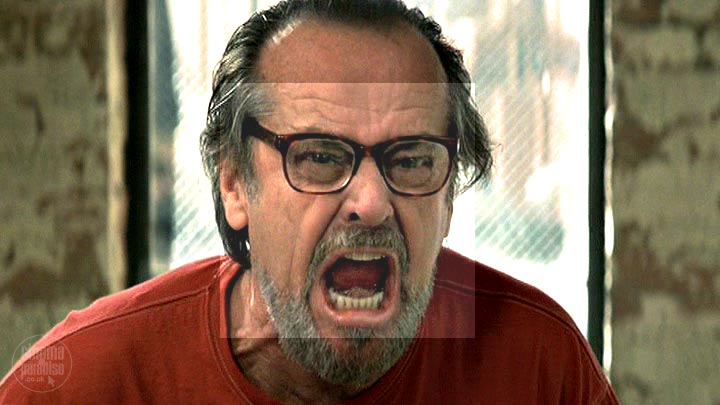

In [82]:
import mediapipe as mp

# MediaPipe 얼굴 인식 설정
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

# 얼굴 인식 모델 초기화
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.5)

# 이미지 로드
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/emotion_recognition/assets/angrysss.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 얼굴 감지
results = face_detection.process(image_rgb)

# 얼굴 위치가 감지되었으면
if results.detections:
    for detection in results.detections:
        # 얼굴 위치 좌표를 그리기
        bboxC = detection.location_data.relative_bounding_box
        ih, iw, _ = image.shape
        x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)

        # 얼굴 위치에 필터 적용
        face_region = image[y:y+h, x:x+w]

        # 필터 예시: 얼굴 밝기 증가
        face_region = cv2.convertScaleAbs(face_region, alpha=1.2, beta=30)  # 밝기 증가

        # 필터를 원본 이미지에 합성
        image[y:y+h, x:x+w] = face_region

cv2_imshow(image)

In [ ]:
model.summary()

Model: "model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)      │ (None, 64, 64, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 62, 62, 8)      │             72 │ input_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 62, 62, 8)      │             32 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 62, 62, 8)      │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 60, 60, 8)      │            576 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 60, 60, 8)      │             32 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 60, 60, 8)      │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 60, 60, 16)     │            200 │ activation_2[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 60, 60, 16)     │             64 │ separable_conv2d_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 60, 60, 16)     │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_2        │ (None, 60, 60, 16)     │            400 │ activation_3[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 60, 60, 16)     │             64 │ separable_conv2d_2[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 30, 30, 16)     │            128 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 30, 30, 16)     │              0 │ batch_normalization_5… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 30, 30, 16)     │             64 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)          

 Total params: 58,423 (228.21 KB)

 Trainable params: 56,951 (222.46 KB)

 Non-trainable params: 1,472 (5.75 KB)